In [320]:
import pandas as pd
import numpy as np
import os
import re
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

In [321]:
movies = pd.read_csv('data/movies.csv')

In [322]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [323]:
raw_genres = movies['genres'].unique()
genres = set(flatten([item.split('|') for item in raw_genres]))
genres.remove("(no genres listed)")
print('Genres', genres)

Genres {'Crime', 'Animation', 'Action', 'Adventure', 'Film-Noir', 'Western', 'Drama', 'Romance', 'Thriller', 'Mystery', 'Horror', 'Children', 'Fantasy', 'Musical', 'IMAX', 'Sci-Fi', 'Documentary', 'Comedy', 'War'}


In [324]:
genre_counts = movies.iloc[:, 4:].sum()  # Assuming genre columns start from the 5th column
genre_counts_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})

## Splitting up DF

In [325]:
def extractGenre(data, genre, column="genres"):
    solution = []
    for i in range(len(data)):
        if genre in data.loc[i, column]:
            solution.append(data.loc[i, :])
    return pd.DataFrame(solution)

In [326]:
genre_dataframes = {}


for genre in genres:
    genre_dataframes[genre] = extractGenre(movies, genre)
    
for genre, dataframe in genre_dataframes.items():
    globals()[f"{genre.lower()}_movies"] = dataframe
    dataframe.to_csv(f"genre_data/{genre.lower()}_movies.csv", index=False)

# Splitting people up

In [327]:
ratings = pd.read_csv("data/ratings.csv")

In [328]:
ratings_summary = ratings.groupby("userId").agg({"movieId": "count", 
                                                 "rating": "mean"})
ratings_summary = ratings_summary.rename(columns={"movieId": "reviewCount", "rating": "averageRating"})
ratings_summary


,reviewCount,averageRating
userId,,
1,232,4.366379
2,29,3.948276
3,39,2.435897
4,216,3.555556
5,44,3.636364
...,...,...
606,1115,3.657399
607,187,3.786096
608,831,3.134176


In [329]:
def summarize_by_genre(genre_df, data=ratings):
    merged_data = data.merge(genre_df, how="inner", on="movieId")

    # Group by userId and calculate average ratings and associated movieId
    summary_df = merged_data.groupby('userId').agg({
        'rating': 'mean',
        'movieId': 'count'
    }).reset_index()
    return summary_df

In [330]:
genre_by_user = {}

for genre in genres:
    summary_df = summarize_by_genre(globals()[f"{genre.lower()}_movies"], ratings)
    summary_df = summary_df.merge(ratings_summary, how = "inner", on = "userId")
    summary_df = summary_df.rename(columns={"movieId": "genreCount"})
    summary_df["percentGenre"] = summary_df["genreCount"]/summary_df["reviewCount"]
    genre_by_user[genre] = summary_df

In [331]:
for genre, dataframe in genre_by_user.items():
    globals()[f"{genre.lower()}_users"] = dataframe
    dataframe.to_csv(f"genre_data/{genre.lower()}_users.csv", index=False)

## Genere Analysis

In [332]:
movies = pd.read_csv('data/movies.csv')
raw_genres = movies['genres'].unique()
genres = set(flatten([item.split('|') for item in raw_genres]))
genres.remove("(no genres listed)")

In [333]:
for genre in genres:
    print(f"{genre.lower()}_users.csv")

crime_users.csv
animation_users.csv
action_users.csv
adventure_users.csv
film-noir_users.csv
western_users.csv
drama_users.csv
romance_users.csv
thriller_users.csv
mystery_users.csv
horror_users.csv
children_users.csv
fantasy_users.csv
musical_users.csv
imax_users.csv
sci-fi_users.csv
documentary_users.csv
comedy_users.csv
war_users.csv


In [334]:
genre_dataframes = {}

for genre in genres:
    filename = f"genre_data/{genre.lower()}_users.csv"
    genre_dataframes[genre] = pd.read_csv(filename)

Using formula $tanh(\frac{P_g * R_g * \ln(C_g)}{2})$

Where $P_g$ is the percentage of movies watched in Genre, $R_g$ is the averaging rating in the genre, and $C_g$ is the count of the movies watch in total.

In [361]:
user_id = ratings_summary.index
user_score = pd.DataFrame(user_id)

for genre, dataframe in genre_dataframes.items():
    df_copy = pd.DataFrame(dataframe["userId"].copy(), columns = ["userId"])
    df_copy[genre] = np.tanh(dataframe["percentGenre"] * dataframe["rating"] * np.log(dataframe["genreCount"])/np.log(np.exp(3)))
    user_score = user_score.merge(df_copy, how = "left", on = "userId")
    
    

In [362]:
user_score

,userId,Crime,Animation,Action,Adventure,Film-Noir,Western,Drama,Romance,Thriller,Mystery,Horror,Children,Fantasy,Musical,IMAX,Sci-Fi,Documentary,Comedy,War
0,1,0.790210,0.577016,0.987007,0.983045,0.000000,0.083679,0.953344,0.481005,0.864969,0.301767,0.235658,0.772182,0.806672,0.427994,NaN,0.714207,NaN,0.978193,0.413374
1,2,0.763989,NaN,0.833333,0.156549,NaN,0.000000,0.973191,0.000000,0.752746,0.063652,0.000000,NaN,NaN,NaN,0.234566,0.242081,0.162702,0.555478,0.000000
2,3,0.005924,0.023693,0.810266,0.547529,NaN,NaN,0.276943,0.034376,0.448099,0.000000,0.582665,0.034376,0.158607,0.000000,NaN,0.897299,NaN,0.167426,0.034376
3,4,0.480685,0.066264,0.390419,0.501137,0.034216,0.134213,0.995853,0.842044,0.639797,0.368856,0.036353,0.134213,0.307763,0.267191,0.000000,0.129647,0.008557,0.989372,0.074933
4,5,0.699312,0.338965,0.435025,0.388122,NaN,0.031496,0.980741,0.549483,0.487412,0.000000,0.000000,0.548259,0.403239,0.261986,0.091296,0.026250,NaN,0.788255,0.083037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0.611007,0.172569,0.616890,0.645959,0.018958,0.049086,0.999936,0.981293,0.804094,0.434350,0.202689,0.194132,0.444080,0.183433,0.040593,0.351417,0.009142,0.991211,0.298270
606,607,0.540681,0.063791,0.966946,0.785103,NaN,0.009884,0.988680,0.545699,0.950725,0.379070,0.722379,0.328509,0.385941,0.051594,0.000000,0.633574,NaN,0.863566,0.079677
607,608,0.783547,0.268897,0.969330,0.838379,0.008341,0.027886,0.974540,0.517125,0.966861,0.393646,0.530526,0.370348,0.557412,0.126942,0.047808,0.811069,0.012936,0.979630,0.080141
608,609,0.326568,0.000000,0.625805,0.580892,NaN,0.000000,0.935120,0.227917,0.798211,NaN,0.043684,0.037450,0.000000,NaN,0.000000,0.214126,0.037450,0.382689,0.173088


In [365]:
user_score_adj = user_score.iloc[:,1:].map(lambda x: 1 if x > 0.8 else (0 if not pd.isna(x) else 0))

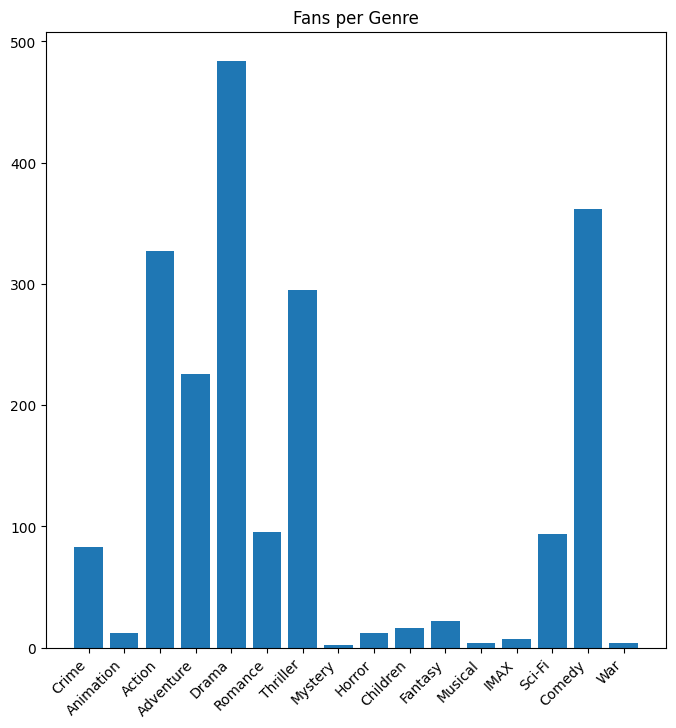

In [366]:
column_sums = user_score_adj.sum()
column_sums = column_sums.loc[column_sums != 0]

plt.figure(figsize=(8, 8))
plt.bar(x = column_sums.index, height = column_sums)
plt.title('Fans per Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

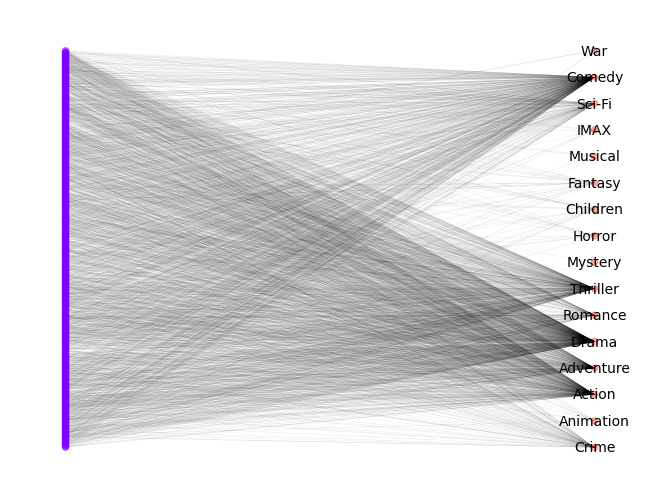

In [367]:
B = nx.Graph()

# Add nodes from rows (index) and columns
B.add_nodes_from(user_score_adj.index, bipartite=0)
B.add_nodes_from(user_score_adj.columns, bipartite=1)

# Add edges based on the non-zero entries in the adjacency matrix
for row_index, row in user_score_adj.iterrows():
    for col_index, value in row.items():
        if value != 0:
            B.add_edge(row_index, col_index, weight=value)

# Find connected components in the bipartite graph
components = list(nx.connected_components(B))

# Select the largest connected component
largest_component = max(components, key=len)

# Create a subgraph containing only the largest connected component
largest_component_graph = B.subgraph(largest_component)

# Assign colors to nodes based on bipartite sets
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use a different layout (spring layout in this case)
colors = [0 if node in user_score_adj.index else 1 for node in largest_component_graph.nodes]

# Use the bipartite layout
pos = nx.bipartite_layout(largest_component_graph, user_score_adj.index)

# Draw the largest connected component using the selected layout
nx.draw(largest_component_graph, pos, with_labels=False, font_weight='bold', node_size=20, font_size=10, width=0.1, node_color=colors, cmap=plt.cm.rainbow, alpha=0.5)

# Add labels for genre nodes
genre_labels = {node: node for node in user_score_adj.columns if node in largest_component_graph.nodes}

nx.draw_networkx_labels(largest_component_graph, pos, labels=genre_labels, font_color='black', font_size=10)

plt.show()